<a href="https://colab.research.google.com/github/bishram-acharya/Cross-Platform-Fingerprint-Matching-using-CNN/blob/main/VGG16_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Platform-Fingerprint-Matching-using-CNN
This project addresses the crucial objective of achieving precise matching between contactless 2D fingerprint images and their contact-based counterparts to enhance the effectiveness of emerging contactless fingerprint technologies.


| Contactbased Image                                             | Contactless Image                                            |
|--------------------------------------------------------------|------------------------------------------------------------|
| ![Contactbased Image](https://raw.githubusercontent.com/bishram-acharya/Cross-Platform-Fingerprint-Matching-using-CNN/main/Images/1.bmp) | ![Contactless Image](https://raw.githubusercontent.com/bishram-acharya/Cross-Platform-Fingerprint-Matching-using-CNN/main/Images/1match.png) |



## Problem Statement
- The existing limitations in accurately matching contactless and contact-based fingerprints pose a significant hurdle in leveraging the advancements of contactless 2D/3Dfingerprint identification systems.
- The lack of a robust and reliable framework capable of accurately comparing and aligning contactless 2D fingerprints with their contact-based counterparts hinders the widespread adoption and efficacy of modern biometric technologies.
- Existing methodologies fail to address the disparities in fingerprint representations
captured by distinct sensor technologies, resulting in a significant decline in matching
accuracy and reliability.

## Dataset
- The dataset was obtained from the University at Buffalo- Center for Unified Biometrics and Sensors. The data consisted of two types of fingerprint images, namely, contact-based and contactless. The number of contact-based images was 920, and contactless images were 11,252.

## Approaches
- VGG16
- DenseNet

## Evaluation
- Accuracy
- Precision
- Recall
- F1 Score
- Area Under ROC Curve
- Equal Error Rate





## Making Necessary Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

In [ ]:

from keras import layers, models
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.losses import binary_crossentropy
import pickle
from keras.models import load_model


## Mounting Drive for accessing dataset
The fingerprint has been updated to our google drive folder minor_project_1 so that colab can access it easily.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Loading Dataset and building model


File path to the CSV file containing data

In [ ]:
file_path_to_df = "/content/drive/My Drive/minor_data/train_improved_images/final.csv"

Creating base model
- Define the base VGG16 model without the fully connected layers (include_top=False)
- Specify the input shape for the model (224x224 pixels with 3 color channels)
- Load the weights pre-trained on ImageNet

In [ ]:
base_model = VGG16(include_top=False, input_shape=(224,224,3),weights='imagenet')

NameError: name 'VGG16' is not defined

Verifying model is correct :

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


Setting up functions we will need to build Siamese Network :

In [ ]:
# Define preprocess_input function for VGG16
preprocess_input=tf.keras.applications.vgg16.preprocess_input

# Set the base model's weights to non-trainable
base_model.trainable = False

# Define a global average pooling layer
pooling=layers.GlobalAveragePooling2D()

# Define a lambda layer to compute the absolute difference between two inputs
distance = layers.Lambda(lambda x: K.abs(x[0] - x[1]), name='distance')

# Define a fully connected dense layer with 126 units and ReLU activation
dense = layers.Dense(126, activation='relu')

# Define a dropout layer with a dropout rate of 0.2
dropout = layers.Dropout(0.2)

# Define the final prediction layer with a single unit and sigmoid activation
prediction = layers.Dense(1, activation='sigmoid', name='output')


The input images to the model will be 224*224 pixels:

In [ ]:
input_shape=(224,224,3)

Building our Siamese Network:

In [ ]:


# Define inputs for the Siamese network
input_a = layers.Input(shape=input_shape, name='input_a')
input_b = layers.Input(shape=input_shape, name='input_b')

# Preprocess input images using VGG16's preprocess_input function
preprocess_output_a = preprocess_input(input_a)
preprocess_output_b = preprocess_input(input_b)

# Pass preprocessed inputs through the base VGG16 model
output_a = base_model(preprocess_output_a, training=False)
output_b = base_model(preprocess_output_b, training=False)

# Apply global average pooling to the output of each branch
pooled_op_a = pooling(output_a)
pooled_op_b = pooling(output_b)

# Calculate the absolute difference between the pooled outputs of the two branches
siamese = distance([pooled_op_a, pooled_op_b])

# Pass the Siamese output through a fully connected dense layer
siamese_op = dense(siamese)

# Apply dropout to prevent overfitting
drop_op = dropout(siamese_op)

# Final prediction using a dense layer with sigmoid activation
output = prediction(drop_op)

# Define the Siamese VGG16 model with inputs and outputs
model = tf.keras.Model(inputs=[input_a, input_b], outputs=output, name='siamese_vgg16')


Let us plot the model and observe what we have built so far:

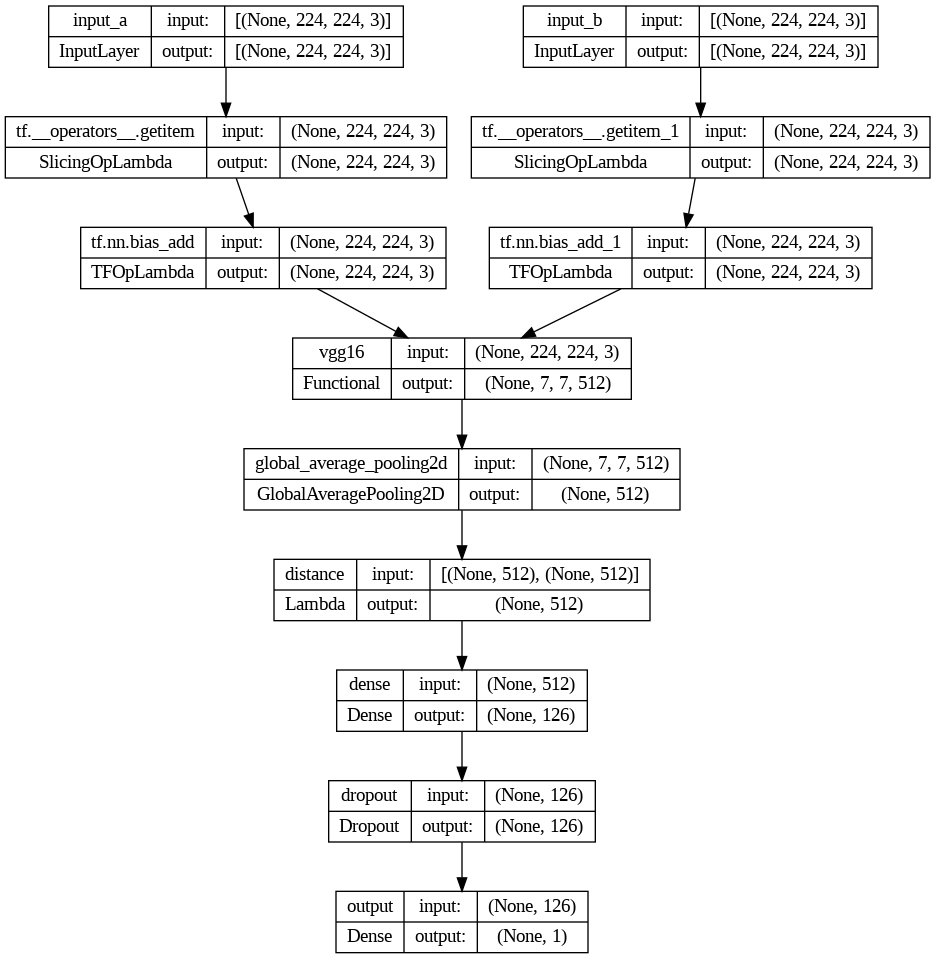

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# Loading Csv file containing path to images alongside label for each image pair
df = pd.read_csv(file_path_to_df)

In [ ]:
# Dropping unnecessary column
df = df.drop('Unnamed: 0', axis=1)

### Pipelining
- In this cell, we will prepare the dataset for training a Siamese VGG16 model.
- We will load contact-based and contactless fingerprint images from their respective paths, preprocess them, and create datasets. Then, we will batch and prefetch the datasets for optimized performance.
- Finally, we will split the dataset into training and validation sets.

In [ ]:
# Define paths for contact-based and contactless images and labels
contactbased_path = tf.data.Dataset.from_tensor_slices('/content/drive/My Drive/minor_data/train_improved_images/resized_contactbased/' + df['contactbased_path'])
contactless_path = tf.data.Dataset.from_tensor_slices('/content/drive/My Drive/minor_data/train_improved_images/segmented_contactless/' + df['contactless_path'])
labels = tf.data.Dataset.from_tensor_slices(df['label'])

# Define functions to load and preprocess contact-based and contactless images
def load_and_preprocess_image_contactbased(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=0)
    # image = tf.image.resize(image, size=(224,224))
    return image

def load_and_preprocess_image_contactless(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    # image = tf.image.resize(image, size=(224,224))
    return image

# Apply mapping functions to datasets to load and preprocess images
contactbased_dataset = contactbased_path.map(load_and_preprocess_image_contactbased, num_parallel_calls=tf.data.experimental.AUTOTUNE)
contactless_dataset = contactless_path.map(load_and_preprocess_image_contactless, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch datasets for optimized performance
batch_size = 32
contactbased_dataset_features = contactbased_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
contactless_dataset_features = contactless_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
labels = labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define function to format data into tuples of features and labels
def format_data(features, labels):
    return features, labels

# Zip datasets together and map the format_data function
train_ds = tf.data.Dataset.zip((contactbased_dataset_features, contactless_dataset_features, labels)).map(format_data)

# Retrieve features and labels for inspection
features, labels = train_ds.as_numpy_iterator().next()

# Calculate the number of training batches
train_batches = tf.data.experimental.cardinality(train_ds)
print(train_batches)

# Split dataset into training and validation sets
val_size = int(0.3 * int(train_batches.numpy()))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

### Compile the model

In [ ]:
# Define the number of initial epochs and the base learning rate for model compilation
initial_epochs = 15
base_learning_rate = 0.0001

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss=binary_crossentropy,
              metrics=['accuracy'])


## Train the model

In [ ]:
# Define the checkpoint path for saving model weights
checkpoint_path = "/content/drive/My Drive/minor_project_1/CP_weights_none.h5"

# Define checkpoint callback to save the best model weights based on validation loss
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

# Train the model on the training dataset with validation data
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

# Save the trained model with no weights
model.save('/content/drive/My Drive/minor_project_1/CP_NONE_WEIGHTS.h5')


Epoch 1/15
810/810 [==============================] - 2086s 2s/step - loss: 0.6936 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 2/15
810/810 [==============================] - 371s 372ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 3/15
810/810 [==============================] - 372s 373ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 4/15
810/810 [==============================] - 375s 374ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6936 - val_accuracy: 0.5013
Epoch 5/15
810/810 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5014

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-4fe46be08ba4>", line 9, in <cell line: 9>
    history=model.fit(train_ds,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1856, in fit
    val_logs = self.evaluate(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate
    logs = test_function_runner.run_step(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step
    tmp_logs = self._function(dataset_or_iterato

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Save the training history to a pickle file
with open('/content/drive/My Drive/minor_project_1/NO_WEIGHTS_hist.pkl', 'wb') as file:
    pickle.dump(history.history, file)


## Finetuning the model

In [ ]:
# Load the saved model
model = load_model('/content/drive/My Drive/minor_project_1/CP_NONE_WEIGHTS.h5')

# Allow fine-tuning of the base model
base_model.trainable = True

# Set the number of layers to fine-tune
fine_tune_at = 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model for fine-tuning
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss=binary_crossentropy,
              metrics=['accuracy'])

# Define checkpoint path for fine-tuned model
checkpoint_path = "/content/drive/My Drive/minor_project_1/NoneWeightsFTcpt.h5"

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define Model Checkpoint callback
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

# Fine-tune the model
history_fine = model.fit(train_ds,
                         epochs=10,
                         validation_data=val_ds,
                         callbacks=[early_stopping, checkpoint_callback])

# Save the fine-tuned model
model.save('/content/drive/My Drive/minor_project_1/FINETUNEDNONEWEIGHTS.h5')

# Save the training history of the fine-tuned model to a pickle file
with open('/content/drive/My Drive/minor_project_1/finetunedNOWEIGHTS.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)


## Observe Training History

In [ ]:
# Extract loss and accuracy values from history
num_epochs = 10
train_loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
train_acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
# epochs = range(1, num_epochs) #doing this because the model only trained till 9 epochs
epochs = range(1, num_epochs + 1)

# Plot loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()